In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/processed-ocean-wave-prediction/cleaned_data.csv
/kaggle/input/waves-measuring-buoys-data-mooloolaba/Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv


In [3]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("/kaggle/input/waves-measuring-buoys-data-mooloolaba/Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv")
df.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45


In [6]:
from datetime import datetime
def fix_date_format(date_str):
    try:
        parts = date_str.split('/')
        year = int(parts[2].split()[0])  # Extract year

        if year >= 2019:
            date_obj = datetime.strptime(date_str, "%d/%m/%Y %H:%M") 
            return date_obj.strftime("%m/%d/%Y %H:%M")  
        return date_str

    except Exception:
        return pd.NaT 

df['Date/Time'] = df['Date/Time'].astype(str).apply(fix_date_format)
df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')


In [7]:
df.set_index('Date/Time', inplace = True)
df.replace(-99.90, np.nan, inplace = True)
df = df.dropna()

In [8]:
df.shape

(43454, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43454 entries, 2017-01-01 01:00:00 to 2019-06-30 23:30:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hs              43454 non-null  float64
 1   Hmax            43454 non-null  float64
 2   Tz              43454 non-null  float64
 3   Tp              43454 non-null  float64
 4   Peak Direction  43454 non-null  float64
 5   SST             43454 non-null  float64
dtypes: float64(6)
memory usage: 2.3 MB


Data Split

In [10]:
lenth = len(df)
train_split = int(0.7 * lenth)
val_split = int(0.85 * lenth)
train_set = df.iloc[:train_split]
val_set = df.iloc[train_split:val_split]
test_set = df.iloc[val_split:]

train_set.shape

(30417, 6)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_ = scaler.fit_transform(train_set)
val_   = scaler.transform(val_set)
test_  = scaler.transform(test_set)

train_set = pd.DataFrame(train_, columns=df.columns, index=train_set.index)
val_set   = pd.DataFrame(val_, columns=df.columns, index=val_set.index)
test_set  = pd.DataFrame(test_, columns=df.columns, index=test_set.index)


In [12]:
def creat_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size]["Hs"])
    return np.array(X), np.array(y)

window_size = 24

X_train, y_train= creat_sequences(train_set, window_size)
X_val, y_val= creat_sequences(val_set, window_size)
X_test, y_test= creat_sequences(test_set, window_size)

Model Establishment

In [13]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import lightning as L
from torch.utils.data import Dataset, DataLoader, random_split
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset   = TimeSeriesDataset(X_val, y_val)
test_dataset  = TimeSeriesDataset(X_test, y_test)

In [15]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
class LSTM(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, dropout, lr):
        super(LSTM, self).__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first = True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()
        self.lr = lr

    def forward(self, x):
        h0 = torch.zeros(self.hparams.num_layers, x.size(0), self.hparams.hidden_size).to(x.device)
        c0 = torch.zeros(self.hparams.num_layers, x.size(0), self.hparams.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x,(h0, c0))
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr = self.lr)
        return optimizer

In [17]:
input_size = len(df.columns); hidden_size = 32; num_layers = 2; dropout = 0.2; lr = 0.001

model = LSTM(input_size, hidden_size, num_layers, dropout, lr)

In [18]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
logger = TensorBoardLogger("lightning_logs", name="wave_model")

In [ ]:
trainer = L.Trainer(
    max_epochs=30,
    logger = logger,
    callbacks=[early_stop_callback],
    accelerator="auto", 
    log_every_n_steps=2
)

trainer.fit(model, train_loader, val_loader)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 13.6 K | train
1 | fc        | Linear  | 33     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
13.6 K    Trainable params
0         Non-trainable params
13.6 K    Total params
0.054     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0007829480455256999   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0007829480455256999}]

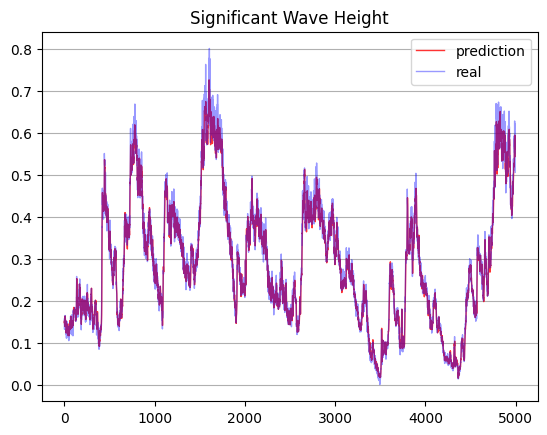

In [30]:
model.eval()

all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        X, _ = batch  # We don't need the true values here
        preds = model(X.to(model.device))
        all_predictions.append(preds.cpu().numpy())

test_prediction = np.concatenate(all_predictions, axis=0)

plt.plot(test_prediction[1500:, 0], color='red', alpha=0.8, linewidth = 1,label='prediction')
plt.plot(y_test[1500:], color='blue', alpha=0.4,linewidth=1, label='real')
plt.title('Significant Wave Height')
plt.legend()
plt.grid(axis='y')